Copyright (c) 2015, 2016 [Sebastian Raschka](sebastianraschka.com)
<br>
2016 [Li-Yi Wei](http://liyiwei.org/)

https://github.com/1iyiwei/pyml

[MIT License](https://github.com/1iyiwei/pyml/blob/master/LICENSE.txt)

# Python Machine Learning - Code Examples

# Chapter 7 - Combining Different Models for Ensemble Learning

Note that the optional watermark extension is a small IPython notebook plugin that I developed to make the code reproducible. You can just skip the following line(s).

In [1]:
%load_ext watermark
%watermark -a '' -u -d -v -p numpy,pandas,matplotlib,scipy,sklearn

last updated: 2016-09-17 

CPython 3.5.2
IPython 4.2.0

numpy 1.11.1
pandas 0.18.1
matplotlib 1.5.1
scipy 0.17.1
sklearn 0.17.1


*The use of `watermark` is optional. You can install this IPython extension via "`pip install watermark`". For more information, please see: https://github.com/rasbt/watermark.*

### Overview

- [Learning with ensembles](#Learning-with-ensembles)
- [Implementing a simple majority vote classifier](#Implementing-a-simple-majority-vote-classifier)
  - [Combining different algorithms for classification with majority vote](#Combining-different-algorithms-for-classification-with-majority-vote)
- [Evaluating and tuning the ensemble classifier](#Evaluating-and-tuning-the-ensemble-classifier)
- [Bagging – building an ensemble of classifiers from bootstrap samples](#Bagging----Building-an-ensemble-of-classifiers-from-bootstrap-samples)
- [Leveraging weak learners via adaptive boosting](#Leveraging-weak-learners-via-adaptive-boosting)
- [Summary](#Summary)

In [2]:
from IPython.display import Image

In [3]:
%matplotlib inline

# Learning with ensembles

Challenge:
* No single classifier best for all circumstances
* Hard to manually decide which classifier/model to use

Solution:
* Combine multipler classifiers for better performance than each individual classifier
* Need diverse, not just accurate, individual classifiers

<a href="https://en.wikipedia.org/wiki/The_Wisdom_of_Crowds"><img src="https://upload.wikimedia.org/wikipedia/en/9/95/Wisecrowds.jpg" align=right></a>

#### Unanimity
* no voting necessary

#### Majority voting
* for binary classification

For sample $x$, each classifier $j$ decides whether the class $C_j(x)$ is $+1$ or $-1$

Majority voting is then:
$$
C(x) = sign\left[ \sum_j C_j(x) \right] = 
\begin{cases}
+1 \; if \; \sum_j C_j(x) \geq 0\\
-1 \; else
\end{cases}
$$

#### Plurality voting
* extension of majority voting for multi-class setting

$$
C(x) = mode\{C_1(x), C_2(x), \cdots, C_m(x) \}
$$

<img src='./images/07_01.png' width=80%>

Individual classifiers can be the same or different types
* decision tree, svm, logistic regression, etc.

Random forest
* combines multiple decision trees

<img src='./images/07_02.png' width=70%> 

# Why ensemble can better than individual classifiers

A simple math model:
* binary classification
* $n$ base classifiers
* each with error rate $\epsilon$
* classifiers make independent decisions

Probability that at least $K$ classifiers are wrong:
$$
\epsilon_{ensemble} (K)
= 
\sum_{k=K}^n C\left(n, k\right) \epsilon^k \left(1-\epsilon\right)^{n-k}
$$
, where $C\left(n, k\right)$ is the combinatorial, i.e. binomial coefficient of n choosing k.

For the ensemble to be wrong, $K \geq \frac{n}{2}$:
$$
\epsilon_{ensemble} = \epsilon_{ensemble}\left( \left\lceil \frac{n}{2} \right\rceil \right)
$$

For example, if
* $n = 11$
* $\epsilon = 0.25$

$\epsilon_{ensemble} = 0.034$

The above assumes classifiers are making independent decisions!

Humans don't always make independent decisions
* elections
* financial markets

<a href="https://books.google.com.hk/books/about/Manias_Panics_and_Crashes.html">
<img src="https://books.google.com.hk/books/content?id=Er-6QkkQkeEC&printsec=frontcover&img=1&zoom=1&edge=curl&imgtk=AFLRE73PgBQLrAIbIXBTXGzeLHPtVy8RRIMF2BN_ugz1l41rEK14FFNcYrKhN2pcU0jdU0vFvIPMCmpWAqKPnJ1PxjnQLzckEiNGJ74SMKbIl3DL2Ct7tkQEgTsRyZl-t_LQeA5W-nc3" align=right>
</a>

In [4]:
# combinatorial C(n, k)
from scipy.misc import comb
import math

def ensemble_error(n_classifier, error):
    k_start = math.ceil(n_classifier / 2.0)
    probs = [comb(n_classifier, k) * error**k * (1-error)**(n_classifier - k)
             for k in range(k_start, n_classifier + 1)]
    return sum(probs)

**Note**

For historical reasons, Python 2.7's `math.ceil` returns a `float` instead of an integer like in Python 3.x. Although Although this book was written for Python >3.4, let's make it compatible to Python 2.7 by casting it to an it explicitely:

In [5]:
from scipy.misc import comb
import math

def ensemble_error(n_classifier, error):
    k_start = int(math.ceil(n_classifier / 2.0))
    probs = [comb(n_classifier, k) * error**k * (1-error)**(n_classifier - k)
             for k in range(k_start, n_classifier + 1)]
    return sum(probs)

In [6]:
ensemble_error(n_classifier=11, error=0.25)

0.034327507019042969

In [7]:
import numpy as np

error_range = np.arange(0.0, 1.01, 0.01)
ens_errors = [ensemble_error(n_classifier=11, error=error)
              for error in error_range]

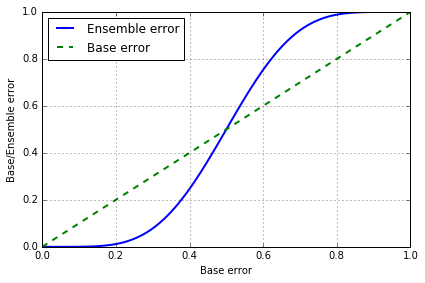

In [8]:
import matplotlib.pyplot as plt

plt.plot(error_range, 
         ens_errors, 
         label='Ensemble error', 
         linewidth=2)

plt.plot(error_range, 
         error_range, 
         linestyle='--',
         label='Base error',
         linewidth=2)

plt.xlabel('Base error')
plt.ylabel('Base/Ensemble error')
plt.legend(loc='upper left')
plt.grid()
plt.tight_layout()
# plt.savefig('./figures/ensemble_err.png', dpi=300)
plt.show()

The ensemble outperforms individual classifiers as long as their base error $\epsilon < 0.5$.

## Excercise

Plot ensembe error versus different number of classifiers.
Does the ensemble error always go down with more classifiers? Why or why not?
Can you fix the issue?

# Ensemble bias and variance

$d_j$ are decisions made by $m$ individual base classifiers

$y$ is the ensemble decision via summation (not really voting for mathematical tractability):
$$
y = \frac{1}{m} \sum_{j=1}^m d_j 
$$

For iid:
$$
\begin{align}
E(y) &= E\left( \frac{1}{m} \sum_{j=1}^m d_j \right) = E(d_j)
\\
Var(y) &= Var\left( \frac{1}{m} \sum_{j=1}^m d_j \right) = \frac{1}{m} Var(d_j)
\end{align}
$$
* The expected value E, and thus bias, remains the same.
* The variance reduces.

For general case:
$$
Var(y) = Var\left( \frac{1}{m} \sum_{j=1}^m d_j \right) = \frac{1}{m^2} \sum_j Var(d_j) + \frac{2}{m^2} \sum_j \sum_{i<j} Cov(d_j, d_i)
$$

So $Var(y)$ increases/decreases for positively/negatively correlated base estimators.

# Diversity versus accuracy

Not possible to have all base estimators accurate and yet negatively correlated.

Why?
* accurate estimators tend to make correct predictions
* correct predictions, by definition, are positively correlated with themselves

Sometimes need intentionally non-optimal base learners for better ensemble performance

# How to achieve diversification and accuracy

Different models/algorithms
* base learners complement each other
* e.g. some parametric, some non-parametric

Different hyper-parameters for the same algorithm/model
* k in KNN
* threshold in decision tree
* kernel function in SVM
* initial weights for perceptron and neural networks

Different input representations of the same event
* sensor fusion, sound and mouth shape for speech recognition
* random subset of features (columns of the data matrix)

Different training sets
* random subset of all samples (rows of the data matrix) - bagging
* sequential training - boosting, cascading inaccurately classified samples

Base learners reasonably instead of very accurate

# How to combine multiple classifiers

## Parallel: multi-expert combination

Base learners work in parallel

Global approach
* all base learners generate outputs for a given input: voting, stacking

Local approach
* select only a few base learners based on the input: gating for mixture of experts

## Sequential: multi-stage combination

Base learners work in series

Later models focus on datasets not well handled by early models: cascading

Start with simpler models, and increasing model complexity only if necessary

# Implementing a simple majority vote classifier 

A (multi-class) majority vote classifier can be implemented via the weighted sum of $m$ individual classifier prediction:
$$
\hat{y} = argmax_i \sum_{j=1}^m w_j \left( C_j(x) = i \right)
$$

Here, $C_j(x) = i$ is a boolean expression for classifier $j$ to predict the class of $x$ to be $i$.

The weights can come from confidence, accuracy, or Bayesian prior of each classifier.
$$
p(C(x) = i \; | \; x) = \sum_{j=1}^m p(C_j) p\left( C_j(x) = i \; | \; C_j \right)
$$

### Equal weighting

If the individual classifiers are weighed equally, the above would reduce to what we see earlier:
$$
\hat{y} = mode\{C_1(x), C_2(x), \cdots, C_m(x) \}
$$

$C_1(x) = 0$,
$C_2(x) = 0$,
$C_3(x) = 1$
$\rightarrow$
$\hat{y} = mode\{0, 0, 1\} = 0$

## Unequal weighting

$w_1 = 0.2$,
$w_2 = 0.2$,
$w_3 = 0.6$
$\rightarrow$
$
\begin{cases}
0.4 & class \; 0 \\
0.6 & class \; 1
\end{cases}
$
$\rightarrow$
$\hat{y} = 1$

In [9]:
import numpy as np

np.argmax(np.bincount([0, 0, 1], 
                      weights=[0.2, 0.2, 0.6]))

1

## Weighted probability

If the individual classifiers can provide prediction probability
$$
p\left(C_j(x) = i\right)
$$
, such as predict_prob() in scikit-learn, we can also predict ensemble class probability:
$$
p\left(C_{ensemble}(x) = i \right) = \sum_{j=1}^m w_j p\left( C_j(x) = i \right)
$$

From which we can decide the predicted class (i.e. predict() in scikit-learn):
$$
\hat{y} = argmax_i \; p\left(C_{ensemble}(x) = i \right)
$$

In the 2-class 3-classifier example above,

$w_1 = 0.2$,
$w_2 = 0.2$,
$w_3 = 0.6$

$$
\begin{align}
C_1(x) &= [0.9, 0.1] 
\\
C_2(x) &= [0.8, 0.2] 
\\
C_3(x) &= [0.4, 0.6] 
\end{align}
$$

Then
$$
\begin{align}
p\left(C_{ensemble} = 0\right) &= 0.2 \times 0.9 + 0.2 \times 0.8 + 0.6 \times 0.4 = 0.58
\\
p\left(C_{ensemble} = 1 \right) &= 0.2 \times 0.1 + 0.2 \times 0.2 + 0.6 \times 0.6 = 0.42
\end{align}
$$

$$
\hat{y} = 0
$$

In [10]:
ex = np.array([[0.9, 0.1],
               [0.8, 0.2],
               [0.4, 0.6]])

p = np.average(ex, 
               axis=0, 
               weights=[0.2, 0.2, 0.6])
p

array([ 0.58,  0.42])

In [11]:
np.argmax(p)

0

# Majority classifier implementation

In [12]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator

# inherits from two classes to get some methods for free
class MajorityVoteClassifier(BaseEstimator, 
                             ClassifierMixin):
    """ A majority vote ensemble classifier

    Parameters
    ----------
    classifiers : array-like, shape = [n_classifiers]
      Different classifiers for the ensemble

    vote : str, {'classlabel', 'probability'} (default='label')
      If 'classlabel' the prediction is based on the argmax of
        class labels. Else if 'probability', the argmax of
        the sum of probabilities is used to predict the class label
        (recommended for calibrated classifiers).

    weights : array-like, shape = [n_classifiers], optional (default=None)
      If a list of `int` or `float` values are provided, the classifiers
      are weighted by importance; Uses uniform weights if `weights=None`.

    """
    def __init__(self, classifiers, vote='classlabel', weights=None):

        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value
                                  in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        """ Fit classifiers.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Matrix of training samples.

        y : array-like, shape = [n_samples]
            Vector of target class labels.

        Returns
        -------
        self : object

        """
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError("vote must be 'probability' or 'classlabel'"
                             "; got (vote=%r)"
                             % self.vote)

        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError('Number of classifiers and weights must be equal'
                             '; got %d weights, %d classifiers'
                             % (len(self.weights), len(self.classifiers)))

        # Use LabelEncoder to ensure class labels start with 0, which
        # is important for np.argmax call in self.predict
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        """ Predict class labels for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Matrix of training samples.

        Returns
        ----------
        maj_vote : array-like, shape = [n_samples]
            Predicted class labels.
            
        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # 'classlabel' vote

            #  Collect results from clf.predict calls
            predictions = np.asarray([clf.predict(X)
                                      for clf in self.classifiers_]).T

            maj_vote = np.apply_along_axis(
                                      lambda x:
                                      np.argmax(np.bincount(x,
                                                weights=self.weights)),
                                      axis=1,
                                      arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        """ Predict class probabilities for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.

        Returns
        ----------
        avg_proba : array-like, shape = [n_samples, n_classes]
            Weighted average probability for each class per sample.

        """
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        """ Get classifier parameter names for GridSearch"""
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['%s__%s' % (name, key)] = value
            return out

In [13]:
import numpy as np
foo = np.asarray([np.random.uniform(size=4) for k in range(3)])
foo.shape

(3, 4)

## Combining different algorithms for classification with majority vote

Let's apply the class we wrote above for classification.

### Load the dataset

Use only 2 features for more challenge

Only last 100 samples in 2 classes

In [14]:
from sklearn import datasets
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test =\
       train_test_split(X, y, 
                        test_size=0.5, 
                        random_state=1)

### Build individual classifiers

Mixed types
* logistic regression
* decision tree
* knn

In [15]:
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.pipeline import Pipeline
import numpy as np

clf1 = LogisticRegression(penalty='l2', 
                          C=0.001,
                          random_state=0)

clf2 = DecisionTreeClassifier(max_depth=1,
                              criterion='entropy',
                              random_state=0)

clf3 = KNeighborsClassifier(n_neighbors=1,
                            p=2,
                            metric='minkowski')

pipe1 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf3]])

clf_labels = ['Logistic Regression', 'Decision Tree', 'KNN']

print('10-fold cross validation:\n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

10-fold cross validation:

ROC AUC: 0.92 (+/- 0.20) [Logistic Regression]
ROC AUC: 0.92 (+/- 0.15) [Decision Tree]
ROC AUC: 0.93 (+/- 0.10) [KNN]


### Majority vote

In [16]:
# Majority Rule (hard) Voting

mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])

clf_labels += ['Majority Voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

ROC AUC: 0.92 (+/- 0.20) [Logistic Regression]
ROC AUC: 0.92 (+/- 0.15) [Decision Tree]
ROC AUC: 0.93 (+/- 0.10) [KNN]
ROC AUC: 0.97 (+/- 0.10) [Majority Voting]


Notice the better performance of ensemble learning

# Evaluating and tuning the ensemble classifier

## Plot ROC curves for test data

TP (true positive) versus FP (false positive) rates

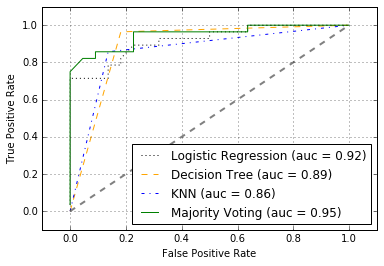

In [17]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls \
        in zip(all_clf,
               clf_labels, colors, linestyles):

    # assuming the label of the positive class is 1
    y_pred = clf.fit(X_train,
                     y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test,
                                     y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr,
             color=clr,
             linestyle=ls,
             label='%s (auc = %0.2f)' % (label, roc_auc))

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
         linestyle='--',
         color='gray',
         linewidth=2)

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# plt.tight_layout()
# plt.savefig('./figures/roc.png', dpi=300)
plt.show()

## Plot decision regions

In [18]:
# for visualization purposes, not necessary for pipelines with standard scalar
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)

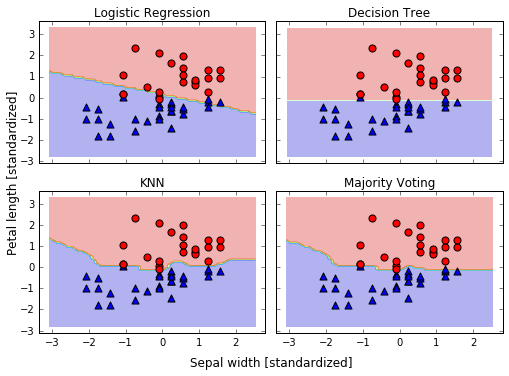

In [19]:
from itertools import product

all_clf = [pipe1, clf2, pipe3, mv_clf]

x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=2, ncols=2, 
                        sharex='col', 
                        sharey='row', 
                        figsize=(7, 5))

for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
    
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0], 
                                  X_train_std[y_train==0, 1], 
                                  c='blue', 
                                  marker='^',
                                  s=50)
    
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0], 
                                  X_train_std[y_train==1, 1], 
                                  c='red', 
                                  marker='o',
                                  s=50)
    
    axarr[idx[0], idx[1]].set_title(tt)

plt.text(-3.5, -4.5, 
         s='Sepal width [standardized]', 
         ha='center', va='center', fontsize=12)
plt.text(-10.5, 4.5, 
         s='Petal length [standardized]', 
         ha='center', va='center', 
         fontsize=12, rotation=90)

plt.tight_layout()
# plt.savefig('./figures/voting_panel', bbox_inches='tight', dpi=300)
plt.show()

Notice the decision boundary from majority voting is a combination of the 3 base classifiers.

# Hyper-parameter tuning for ensemble learning

## Get the parameter names 

In [20]:
mv_clf.get_params()

{'decisiontreeclassifier': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
             max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             presort=False, random_state=0, splitter='best'),
 'decisiontreeclassifier__class_weight': None,
 'decisiontreeclassifier__criterion': 'entropy',
 'decisiontreeclassifier__max_depth': 1,
 'decisiontreeclassifier__max_features': None,
 'decisiontreeclassifier__max_leaf_nodes': None,
 'decisiontreeclassifier__min_samples_leaf': 1,
 'decisiontreeclassifier__min_samples_split': 2,
 'decisiontreeclassifier__min_weight_fraction_leaf': 0.0,
 'decisiontreeclassifier__presort': False,
 'decisiontreeclassifier__random_state': 0,
 'decisiontreeclassifier__splitter': 'best',
 'pipeline-1': Pipeline(steps=[['sc', StandardScaler(copy=True, with_mean=True, with_std=True)], ['clf', LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=

## Grid search parameters

In [21]:
from sklearn.grid_search import GridSearchCV

params = {'decisiontreeclassifier__max_depth': [1, 2],
          'pipeline-1__clf__C': [0.001, 0.1, 100.0]}

grid = GridSearchCV(estimator=mv_clf,
                    param_grid=params,
                    cv=10,
                    scoring='roc_auc')
grid.fit(X_train, y_train)

for params, mean_score, scores in grid.grid_scores_:
    print("%0.3f+/-%0.2f %r"
          % (mean_score, scores.std() / 2.0, params))

0.967+/-0.05 {'pipeline-1__clf__C': 0.001, 'decisiontreeclassifier__max_depth': 1}
0.967+/-0.05 {'pipeline-1__clf__C': 0.1, 'decisiontreeclassifier__max_depth': 1}
1.000+/-0.00 {'pipeline-1__clf__C': 100.0, 'decisiontreeclassifier__max_depth': 1}
0.967+/-0.05 {'pipeline-1__clf__C': 0.001, 'decisiontreeclassifier__max_depth': 2}
0.967+/-0.05 {'pipeline-1__clf__C': 0.1, 'decisiontreeclassifier__max_depth': 2}
1.000+/-0.00 {'pipeline-1__clf__C': 100.0, 'decisiontreeclassifier__max_depth': 2}


In [22]:
print('Best parameters: %s' % grid.best_params_)
print('Accuracy: %.2f' % grid.best_score_)

Best parameters: {'pipeline-1__clf__C': 100.0, 'decisiontreeclassifier__max_depth': 1}
Accuracy: 1.00


Observations:
* decision tree depth doesn't matter
* lower regularization (larger $C$) better

**Note**  
By default, the default setting for `refit` in `GridSearchCV` is `True` (i.e., `GridSeachCV(..., refit=True)`), which means that we can use the fitted `GridSearchCV` estimator to make predictions via the `predict` method, for example:

    grid = GridSearchCV(estimator=mv_clf, 
                        param_grid=params, 
                        cv=10, 
                        scoring='roc_auc')
    grid.fit(X_train, y_train)
    y_pred = grid.predict(X_test)

In addition, the "best" estimator can directly be accessed via the `best_estimator_` attribute.

In [23]:
grid.best_estimator_.classifiers

[Pipeline(steps=[['sc', StandardScaler(copy=True, with_mean=True, with_std=True)], ['clf', LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False)]]),
 DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
             max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             presort=False, random_state=0, splitter='best'),
 Pipeline(steps=[['sc', StandardScaler(copy=True, with_mean=True, with_std=True)], ['clf', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=None, n_jobs=1, n_neighbors=1, p=2,
            weights='uniform')]])]

In [24]:
mv_clf = grid.best_estimator_

In [25]:
mv_clf.set_params(**grid.best_estimator_.get_params())

MajorityVoteClassifier(classifiers=[Pipeline(steps=[['sc', StandardScaler(copy=True, with_mean=True, with_std=True)], ['clf', LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solv...ski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')]])],
            vote='classlabel', weights=None)

In [26]:
mv_clf

MajorityVoteClassifier(classifiers=[Pipeline(steps=[['sc', StandardScaler(copy=True, with_mean=True, with_std=True)], ['clf', LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solv...ski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')]])],
            vote='classlabel', weights=None)

# Bagging -- Building an ensemble of classifiers from bootstrap samples

Use random subsets of samples for each base classifier.
* bootstrap samples: random sample with replacement of the entire training data

<img src='./images/07_06.png'> 

7-sample training data example:
<img src='./images/07_07.png'> 

## Bagging and Random forest

Random forest selects random subset of features.

# Bagging example

Classify the wine data set

## Load the dataset

In [27]:
import pandas as pd

remote_source = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data'
local_source = '../datasets/wine/wine.data'

df_wine = pd.read_csv(local_source, header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

# drop 1 class
df_wine = df_wine[df_wine['Class label'] != 1]

y = df_wine['Class label'].values
X = df_wine[['Alcohol', 'Hue']].values

## Encoding and splitting

In [28]:
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split

le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test =\
            train_test_split(X, y, 
                             test_size=0.40, 
                             random_state=1)

## Bagging classifier

In [29]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=None, # allow over-fitting to enhance diversity
                              random_state=1)

bag = BaggingClassifier(base_estimator=tree,
                        n_estimators=500, 
                        max_samples=1.0, 
                        max_features=1.0, 
                        bootstrap=True, 
                        bootstrap_features=False, 
                        n_jobs=1, 
                        random_state=1)

In [30]:
from sklearn.metrics import accuracy_score

tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f'
      % (tree_train, tree_test))

bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)

bag_train = accuracy_score(y_train, y_train_pred) 
bag_test = accuracy_score(y_test, y_test_pred) 
print('Bagging train/test accuracies %.3f/%.3f'
      % (bag_train, bag_test))

Decision tree train/test accuracies 1.000/0.833
Bagging train/test accuracies 1.000/0.896


Notice bagging has less over-fitting than decision tree.

## Visualize decision regions

Use meshgrid and isocontour as usual.

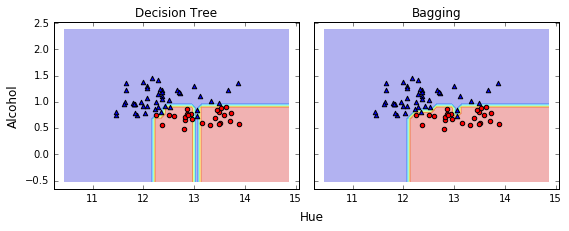

In [31]:
import numpy as np
import matplotlib.pyplot as plt

x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=1, ncols=2, 
                        sharex='col', 
                        sharey='row', 
                        figsize=(8, 3))


for idx, clf, tt in zip([0, 1],
                        [tree, bag],
                        ['Decision Tree', 'Bagging']):
    clf.fit(X_train, y_train)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train == 0, 0],
                       X_train[y_train == 0, 1],
                       c='blue', marker='^')

    axarr[idx].scatter(X_train[y_train == 1, 0],
                       X_train[y_train == 1, 1],
                       c='red', marker='o')

    axarr[idx].set_title(tt)

axarr[0].set_ylabel('Alcohol', fontsize=12)
plt.text(10.2, -1.2,
         s='Hue',
         ha='center', va='center', fontsize=12)

plt.tight_layout()
# plt.savefig('./figures/bagging_region.png',
#            dpi=300,
#            bbox_inches='tight')
plt.show()

Notice the smoother decision boundaries of bagging than decision tree.

Bagging can reduce variance, but not bias.

Choose base classifiers with low bias, such as unpruned decision trees.

# Leveraging weak learners via adaptive boosting

AdaBoost for abbreviation

A collection of weak base learners (diversity over accuracy)
* sequential learning
* later classifiers focus on the weak parts (mis-classified samples) of the earlier classifiers

## Original boosting procedure [Schapire 1990]

Using 3 classifiers

Training:
* Train $C_1$ with a random subset of training data

* Train $C_2$ with a random subset of (training data $\bigcup$ misclassified samples from $C_1$)

* Train $C_3$ over the training samples for which $C_1$ and $C_2$ disagree

Testing/Usage:
* Combine $C_1$, $C_2$, $C_3$ via majority voting

## AdaBoost versus bagging

Bagging
* parallel
* random sample with replacement
* cannot reduce bias; same as base classifiers

AdaBoost
* sequential
* random sample without replacement
* can reduce bias

## AdaBoost example

Give previously misclassified samples higher weights

Example using decision tree stumps (i.e. very shallow trees, like just one level)

Steps:
1. equal weight training of all samples by $C_1$, two blue circles are misclassified
2. larger/lower weights to wrongly/correctly classified samples, train $C_2$
3. larger/lower weights to wrongly/correctly classified samples, train $C_3$
4. combine $C_1$, $C_2$, $C_3$ for weighted majority voting

<img src='./images/07_09.png' width=80%>

## AdaBoost algorithm

Input data: $X$ and $y$ (label)

Initial equal weight vector $w$ to all samples, \sum_i w_i = 1

For j in m boosting rounds, do the following:
1. Train a weak learner: $C_j.train(X, y, w)$
2. Predict class labels: $\hat{y} = C_j.predict(X)$
3. Compute weighted error rate: $\epsilon = w . \left(\hat{y} \neq y \right)$, $0 \leq \epsilon < 0.5$
4. Compute re-weighting coefficients: $\alpha_i = 0.5 \log_e\left(\frac{1-\epsilon}{\epsilon}\right)$, $\geq0$ for $0 \leq \epsilon < 0.5$ 
 * $\epsilon \uparrow$ $\rightarrow$ $\alpha \downarrow$
 * $\epsilon = 0$ $\rightarrow$ $\alpha_i = \infty$ - equal weighting if no error
 * $\epsilon = 0.5$ $\rightarrow$ $\alpha_i = 0$ - no weight update if serious errors
5. Update weights: $w \leftarrow w \times \exp(-\alpha_i . \hat{y} \times y)$, $\times$ means element-wise product
 * correct/incorrect prediction will decrease/increase weight
6. Normalize weights: $w \leftarrow \frac{w}{\sum_i w_i}$

Compute final prediction via weighted ensemble voting:
$
\hat{y} = \sum_j \alpha_j \times C_j.predict(X)
$

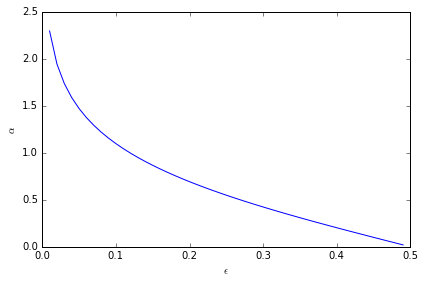

In [32]:
import matplotlib.pyplot as plt
import numpy as np

def alpha_func(x):
    return 0.5*np.log((1-x)/x)

delta = 0.01
x = np.arange(delta, 0.5, delta)
y = alpha_func(x)

plt.plot(x, y)
plt.xlabel(r'$\epsilon$')
plt.ylabel(r'$\alpha$')
plt.tight_layout()
plt.show()

10 sample example

$\epsilon = 0.3$

$\alpha = 0.5\log_e(0.7/0.3) = 0.424$

$w$ before normalization:
* correct prediction: $0.1 \times \exp(-0.424 \times 1 \times 1) = 0.066$
* incorrect prediction: $0.1 \times \exp(-0.424 \times 1 \times -1) = 0.153$

<img src='./images/07_10.png' width=80%>

# AdaBoost code example

In [33]:
from sklearn.ensemble import AdaBoostClassifier

tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=1,
                              random_state=0)

ada = AdaBoostClassifier(base_estimator=tree,
                         n_estimators=500, 
                         learning_rate=0.1,
                         random_state=0)

In [34]:
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f'
      % (tree_train, tree_test))

ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)

ada_train = accuracy_score(y_train, y_train_pred) 
ada_test = accuracy_score(y_test, y_test_pred) 
print('AdaBoost train/test accuracies %.3f/%.3f'
      % (ada_train, ada_test))

Decision tree train/test accuracies 0.845/0.854
AdaBoost train/test accuracies 1.000/0.875


Better training performance by AdaBoost with more overfitting than bagging

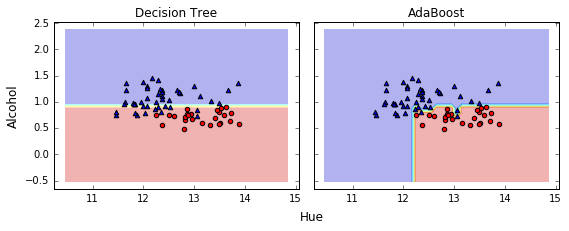

In [35]:
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(8, 3))


for idx, clf, tt in zip([0, 1],
                        [tree, ada],
                        ['Decision Tree', 'AdaBoost']):
    clf.fit(X_train, y_train)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train == 0, 0],
                       X_train[y_train == 0, 1],
                       c='blue', marker='^')
    axarr[idx].scatter(X_train[y_train == 1, 0],
                       X_train[y_train == 1, 1],
                       c='red', marker='o')
    axarr[idx].set_title(tt)

axarr[0].set_ylabel('Alcohol', fontsize=12)
plt.text(10.2, -1.2,
         s='Hue',
         ha='center', va='center', fontsize=12)

plt.tight_layout()
# plt.savefig('./figures/adaboost_region.png',
#           dpi=300,
#           bbox_inches='tight')
plt.show()

AdaBoost has more complex decision boundary than decision tree, as expected.


# Summary

Combine multiple (independent) base learners can improve performance
* majority voting
* bagging - parallel
* AdaBoost - sequential

Choose diverse, not just, accurate base learners
* variance and bias trade off

Ensemble learning computationally more expensive

Netflix price

# Reading

* PML Chapter 7
* IML Chapter 17.1-17.7